<center><h1>DSCI-552 HOMEWORK 2</h1>
<br>
<font size="3">Name: Vorapoom Thirapatarapong</font>
<br>
<font size="3">USC ID: 4397330150 Github Username: bvorapoom</font></center>

<b> Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import cdist

<b> Download dataset

In [2]:
df_ccpp = pd.read_excel('../data/CCPP/Folds5x2_pp.xlsx', sheet_name = 'Sheet1', header = 0)
print(df_ccpp)

         AT      V       AP     RH      PE
0     14.96  41.76  1024.07  73.17  463.26
1     25.18  62.96  1020.04  59.08  444.37
2      5.11  39.40  1012.16  92.14  488.56
3     20.86  57.32  1010.24  76.64  446.48
4     10.82  37.50  1009.23  96.62  473.90
...     ...    ...      ...    ...     ...
9563  16.65  49.69  1014.01  91.00  460.03
9564  13.19  39.18  1023.67  66.78  469.62
9565  31.32  74.33  1012.92  36.48  429.57
9566  24.48  69.45  1013.86  62.39  435.74
9567  21.60  62.52  1017.23  67.87  453.28

[9568 rows x 5 columns]


# (b) Exploring the data

<font size = "3"><b> (b)-i. How many rows are in this data set? How many columns? What do the rows and columns represent? </font>

In [3]:
# exploring rows and columns of the dataset
df_ccpp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


> - The dataset contains 9,568 rows and 5 columns
> - The 5 columns represent the power plant's attributes: Ambient Temperature (AT), Ambient Pressure (AP), Relative Humidity (RH), Exhaust Vacuum (V), net hourly electrical energy output (PE). The first 4 attributes will be used as independent variables while the last attribute is the dependent variable.
> - Each of the 9,569 rows in the dataset represent the hourly-average records of the power plant's attributes (the dataset's columns) from 2006 to 2011 when the plan was set to work full load.
> - all the columns do not contain missing values

<font size = "3"><b> (b)-ii. Make pairwise scatterplots of all the variables in the data set including the predictors (independent variables) with the dependent variable. Describe your findings. </font>

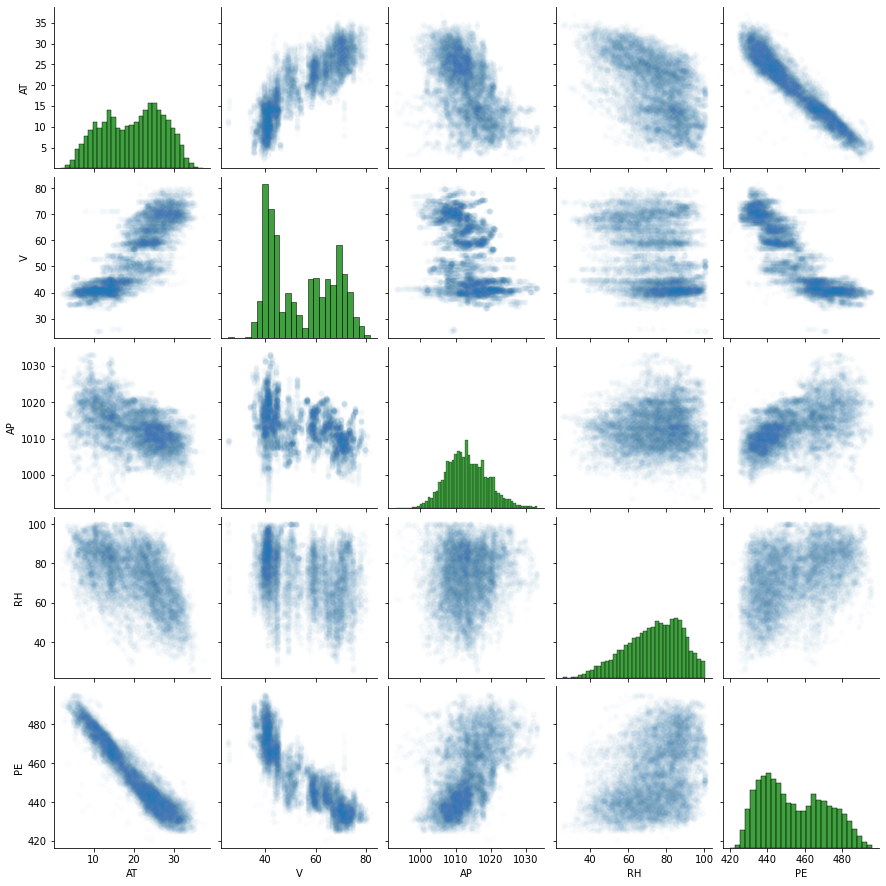

In [4]:
# create pairplot between each of the variables in the dataset
sns.pairplot(df_ccpp, kind = 'scatter', plot_kws = {'alpha': 0.02}, diag_kws = {'color' : 'g'})
plt.show()

> - Looking at the histogram of each variable, the variables 'AT' and 'AP' seem to have a normal distribution, the variable 'RH' seem to be left-skewed, and the variables 'V' and 'PE' seem to be bimodal
> - Looking at the scatter plots between the independent variables, there seems to be a positive correlation between variable 'V' and 'AT' while the other pairs do not seem to show any apparent correlation
> - Looking at the scatter plots between each independent variable versus the dependent variable 'PE', there seem to be a strong negative correlation of the variables 'AT' and 'V' while variables 'AP' and 'RH' seem to have a  positive correlation.

<font size = "3"><b> (b)-iii. What are the mean, the median, range, first and third quartiles, and interquartile ranges of each of the variables in the dataset? Summarize them in a table. </font>

In [5]:
# statistical summary of each attribute
stats_sum_ccpp = df_ccpp.describe()
stats_sum_ccpp.loc['range'] = stats_sum_ccpp.loc['max'] - stats_sum_ccpp.loc['min']
stats_sum_ccpp.loc['IQR'] = stats_sum_ccpp.loc['75%'] - stats_sum_ccpp.loc['25%']
stats_sum_ccpp = stats_sum_ccpp.rename(index = {'50%':'median', '25%':'1st_quartile', '75%':'3rd_quartile'})
stats_sum_ccpp = round(stats_sum_ccpp, 2)
stats_sum_ccpp = stats_sum_ccpp.loc[['mean', 'median', 'range', '1st_quartile', '3rd_quartile', 'IQR'], :]
display(stats_sum_ccpp)


,AT,V,AP,RH,PE
mean,19.65,54.31,1013.26,73.31,454.37
median,20.34,52.08,1012.94,74.97,451.55
range,35.30,56.20,40.41,74.60,75.50
1st_quartile,13.51,41.74,1009.10,63.33,439.75
3rd_quartile,25.72,66.54,1017.26,84.83,468.43
IQR,12.21,24.80,8.16,21.50,28.68


# (c) For each predictor, fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions. Are there any outliers that you would like to remove from your data for each of these regression tasks?

In [6]:
# function for fitting linear regression
def sm_linear_regression(X_train, y_train):
    X_train_const = sm.add_constant(X_train)
    linreg = sm.OLS(y_train, X_train_const).fit()
    return linreg
    
# function for plotting raw data and output regressor
def plot_linreg(X_train, y_train, linreg):
    plt.rcParams["figure.figsize"] = (12,6)
    plt.scatter(X_train, y_train, c = 'grey')
    plt.plot(X_train, linreg.params[0] + linreg.params[1] * X_train, c = 'r')

    plt.title("Linear Regression Plot between '" + X_train.columns[0] + "' and 'PE'", fontsize = 'xx-large')
    plt.xlabel(X_train.columns[0])
    plt.ylabel('PE')
    plt.show()
    
# function for plotting studentized residuals for identifying outliers
def plot_studentized_residuals(X_train, stu_res):
    plt.rcParams["figure.figsize"] = (12,6)
    plt.scatter(X_train, stu_res, c = 'grey')
    plt.axhline(y = 3, color = 'r', linestyle = '-')
    plt.axhline(y = -3, color = 'r', linestyle = '-')

    plt.title("Studentized Residuals Plot between '" + X_train.columns[0] + "' and 'PE'", fontsize = 'xx-large')
    plt.xlabel(X_train.columns[0])
    plt.ylabel('Studentized Residuals')
    plt.grid()
    plt.show()

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:30:55   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        497.0341      0.156   3177.280      0.0

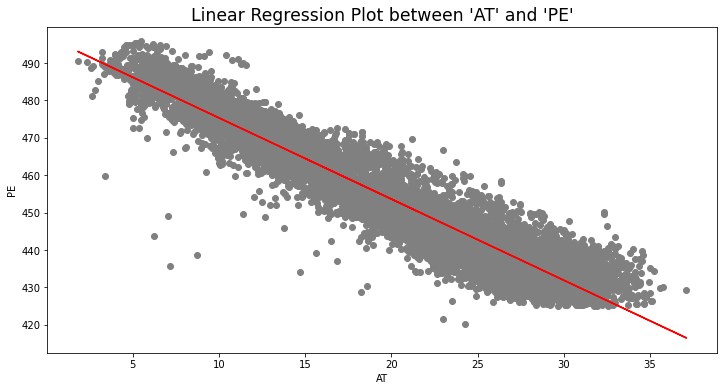

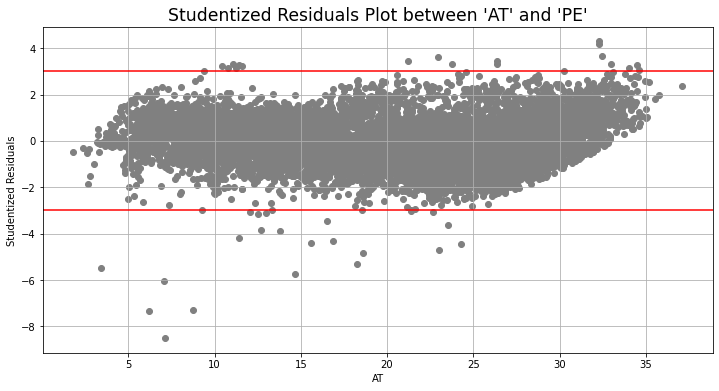

Number of Outliers detected using Studentized Residuals over 3 or under -3 =  42


In [7]:
# LinReg 1 predictor - AT

# define X and y
X_train = df_ccpp[['AT']]
y_train = df_ccpp['PE']

# fit linear regression
linreg_AT = sm_linear_regression(X_train, y_train)
print(linreg_AT.summary())
print('MSE of univariate LinReg using AT:', mean_squared_error(y_train, linreg_AT.predict(sm.add_constant(X_train))))

# plot raw data and linear regressor
plot_linreg(X_train, y_train, linreg_AT)

# plot studentized residuals to detect outliers
stu_res = linreg_AT.outlier_test()['student_resid']
plot_studentized_residuals(X_train, stu_res)
outliers_cnt = (np.abs(stu_res) > 3).sum()
print('Number of Outliers detected using Studentized Residuals over 3 or under -3 = ', outliers_cnt)

> - Using feature 'AT' to fit the linear regression, there is a statistically significant association since the p-value is 0.000. The scatterplot between 'AT' and 'PE' along with its linear regressor also show that the regressor fits to the data quite well with an R-squared of 0.899
> - Using stedentized residuals plot to identify outliers where the threshold is set between -3 and 3, there will be 42 data points that lie outside this threshold and will be considered as outliers when considering feature 'AT'

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.972e+04
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:31:05   Log-Likelihood:                -33963.
No. Observations:                9568   AIC:                         6.793e+04
Df Residuals:                    9566   BIC:                         6.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        517.8015      0.378   1370.218      0.0

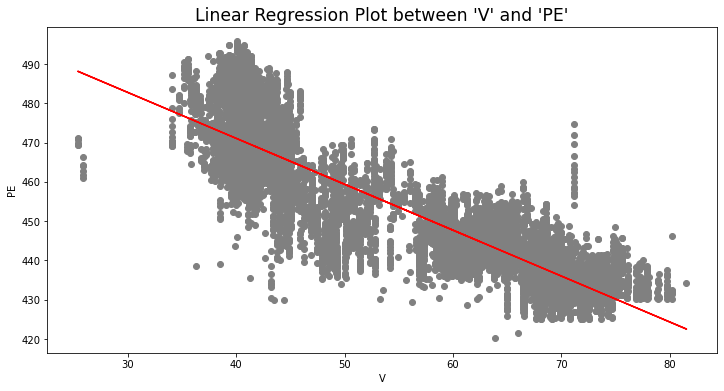

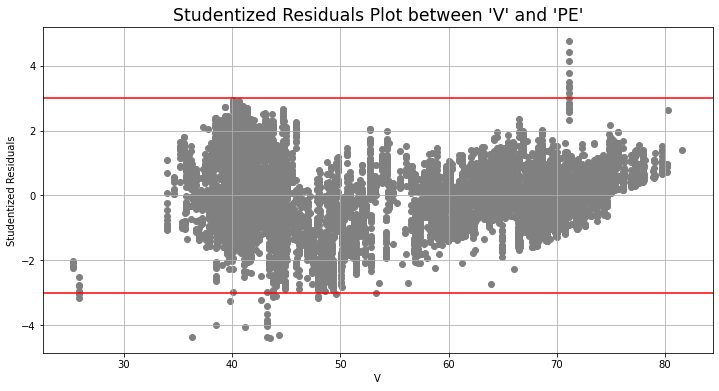

Number of Outliers detected using Studentized Residuals over 3 or under -3 =  33


In [8]:
# LinReg 1 predictor - V

# define X and y
X_train = df_ccpp[['V']]
y_train = df_ccpp['PE']

# fit linear regression
linreg_V = sm_linear_regression(X_train, y_train)
print(linreg_V.summary())
print('MSE of univariate LinReg using V:', mean_squared_error(y_train, linreg_V.predict(sm.add_constant(X_train))))

# plot raw data and linear regressor
plot_linreg(X_train, y_train, linreg_V)

# plot studentized residuals to detect outliers
stu_res = linreg_V.outlier_test()['student_resid']
plot_studentized_residuals(X_train, stu_res)
outliers_cnt = (np.abs(stu_res) > 3).sum()
print('Number of Outliers detected using Studentized Residuals over 3 or under -3 = ', outliers_cnt)

> - Using feature 'V' to fit the linear regression, there is a statistically significant association since the p-value is 0.000. The scatterplot between 'V' and 'PE' along with its linear regressor also show that the regressor fits to the data quite well with an R-squared of 0.757
> - Using stedentized residuals plot to identify outliers where the threshold is set between -3 and 3, there will be 33 data points that lie outside this threshold and will be considered as outliers when considering feature 'V'

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     3516.
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:31:15   Log-Likelihood:                -39224.
No. Observations:                9568   AIC:                         7.845e+04
Df Residuals:                    9566   BIC:                         7.847e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1055.2610     25.459    -41.449      0.0

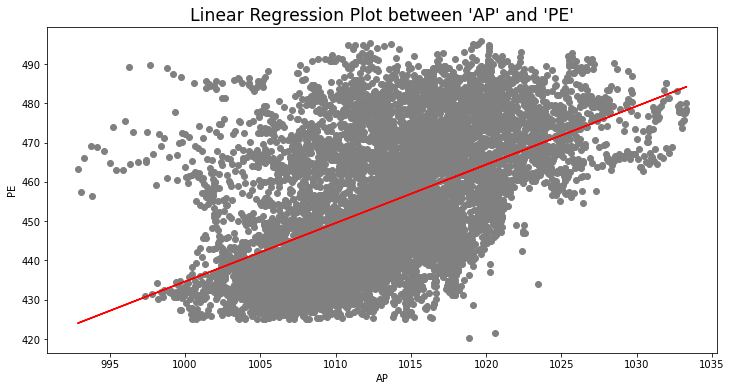

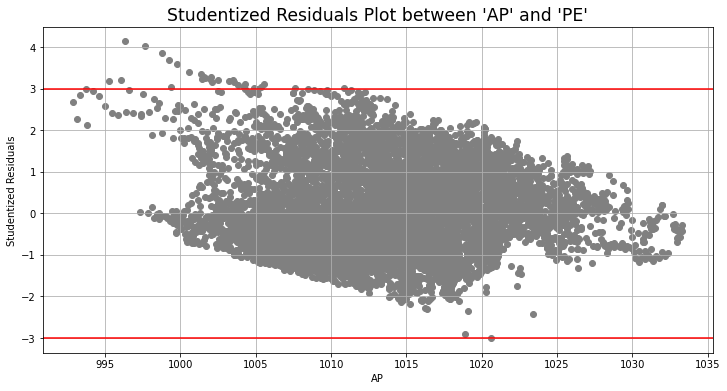

Number of Outliers detected using Studentized Residuals over 3 or under -3 =  30


In [9]:
# LinReg 1 predictor - AP

# define X and y
X_train = df_ccpp[['AP']]
y_train = df_ccpp['PE']

# fit linear regression
linreg_AP = sm_linear_regression(X_train, y_train)
print(linreg_AP.summary())
print('MSE of univariate LinReg using AP:', mean_squared_error(y_train, linreg_AP.predict(sm.add_constant(X_train))))

# plot raw data and linear regressor
plot_linreg(X_train, y_train, linreg_AP)

# plot studentized residuals to detect outliers
stu_res = linreg_AP.outlier_test()['student_resid']
plot_studentized_residuals(X_train, stu_res)
outliers_cnt = (np.abs(stu_res) > 3).sum()
print('Number of Outliers detected using Studentized Residuals over 3 or under -3 = ', outliers_cnt)

> - Using feature 'AP' to fit the linear regression, there is a statistically significant association since the p-value is 0.000. However, the scatterplot between 'AP' and 'PE' doesn't show a very strong linear relationship and its R-squared is quite low at 0.269
> - Using stedentized residuals plot to identify outliers where the threshold is set between -3 and 3, there will be 30 data points that lie outside this threshold and will be considered as outliers when considering feature 'AP'

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1714.
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:31:28   Log-Likelihood:                -39933.
No. Observations:                9568   AIC:                         7.987e+04
Df Residuals:                    9566   BIC:                         7.988e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        420.9618      0.823    511.676      0.0

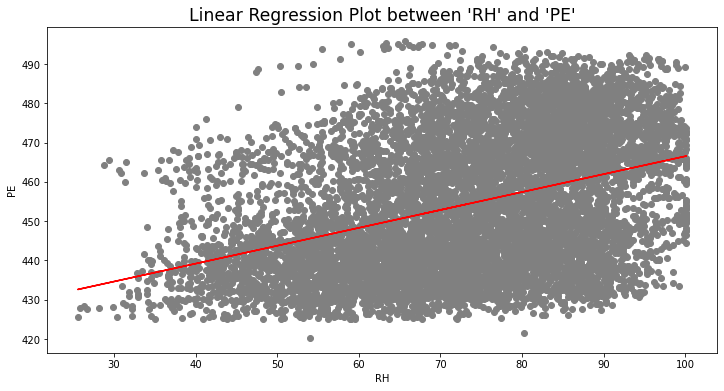

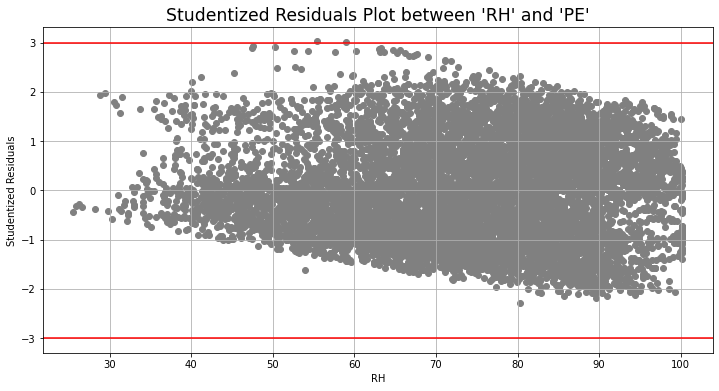

Number of Outliers detected using Studentized Residuals over 3 or under -3 =  2


In [10]:
# LinReg 1 predictor - RH

# define X and y
X_train = df_ccpp[['RH']]
y_train = df_ccpp['PE']

# fit linear regression
linreg_RH = sm_linear_regression(X_train, y_train)
print(linreg_RH.summary())
print('MSE of univariate LinReg using RH:', mean_squared_error(y_train, linreg_RH.predict(sm.add_constant(X_train))))

# plot raw data and linear regressor
plot_linreg(X_train, y_train, linreg_RH)

# plot studentized residuals to detect outliers
stu_res = linreg_RH.outlier_test()['student_resid']
plot_studentized_residuals(X_train, stu_res)
outliers_cnt = (np.abs(stu_res) > 3).sum()
print('Number of Outliers detected using Studentized Residuals over 3 or under -3 = ', outliers_cnt)

> - Using feature 'RH' to fit the linear regression, there is a statistically significant association since the p-value is 0.000. However, the scatterplot between 'RH' and 'PE' doesn't show a very strong linear relationship and its R-squared is quite low at 0.152
> - Using stedentized residuals plot to identify outliers where the threshold is set between -3 and 3, there will be 2 data points that lie outside this threshold and will be considered as outliers when considering feature 'RH'

# (d) Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis H0 :βj =0?

In [11]:
# LinReg using all 4 predictors

# define X and y
X_train = df_ccpp[['AT', 'V', 'AP', 'RH']]
y_train = df_ccpp['PE']

# fit linear regression
linreg_all = sm_linear_regression(X_train, y_train)
print(linreg_all.summary())
print('MSE of multiple LinReg:', mean_squared_error(y_train, linreg_all.predict(sm.add_constant(X_train))))


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:31:40   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.0

> When using all features AT, V, AP, and RH, all of the predictors are statistically significant as their p-values are at 0.000. The R-squared of this multiple regression is also high at 0.929 as well as its training MSE at 20.77

# (e) How do your results from 1c compare to your results from 1d? Create a plot displaying the univariate regression coefficients from 1c on the x-axis, and the multiple regression coefficients from 1d on the y-axis. That is, each predictor is displayed as a single point in the plot. Its coefficient in a simple linear regression model is shown on the x-axis, and its coefficient estimate in the multiple linear regression model is shown on the y-axis.

> The result of using univariate LinReg (1c) compared to multiple regression (1d) shows that multiple regression can fit the data better according to its training set performance. The R-squared of multiple regression is at 0.929 when the best R-squared from univariate regression is at 0.899. The MSE of multiple regression is at 20.767 when the best MSE from univariate regression is at 29.432

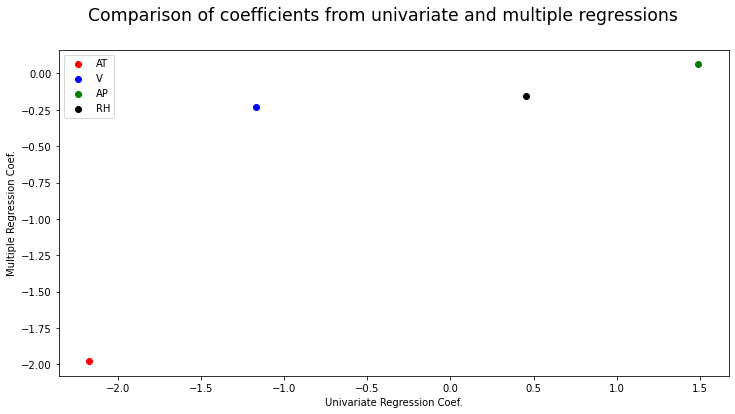

In [12]:
# Comparing coefficients from univariate vs multiple regression
plt.scatter(linreg_AT.params[1], linreg_all.params[1], color = 'r', label = 'AT')
plt.scatter(linreg_V.params[1], linreg_all.params[2], color = 'b', label = 'V')
plt.scatter(linreg_AP.params[1], linreg_all.params[3], color = 'g', label = 'AP')
plt.scatter(linreg_RH.params[1], linreg_all.params[4], color = 'black', label = 'RH')
plt.suptitle('Comparison of coefficients from univariate and multiple regressions', fontsize = 'xx-large')
plt.xlabel('Univariate Regression Coef.')
plt.ylabel('Multiple Regression Coef.')
plt.legend()
plt.show()

# (f) Is there evidence of nonlinear association between any of the predictors and the response? To answer this question, for each predictor X, fit a model of the form2 
# Y =β0 +β1X+β2X2 +β3X3 +ε

In [13]:
# function for fitting polynomial regression using statsmodels formula
def smf_linear_regression(model, df):
    linreg = smf.ols(formula = model, data = df).fit()
    return linreg

# function for plotting raw data and output regressor
def plot_linreg_poly(X_train, y_train, linreg):
    plt.rcParams["figure.figsize"] = (12,6)
    plt.scatter(X_train, y_train, c = 'grey')
    plt.plot(X_train.sort_values(X_train.columns[0]), linreg.predict(X_train.sort_values(X_train.columns[0])), c = 'r')

    plt.title("Linear Regression Plot between '" + X_train.columns[0] + "' and 'PE'", fontsize = 'xx-large')
    plt.xlabel(X_train.columns[0])
    plt.ylabel('PE')
    plt.show()

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:31:40   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      492.7281      0.673    732.248   

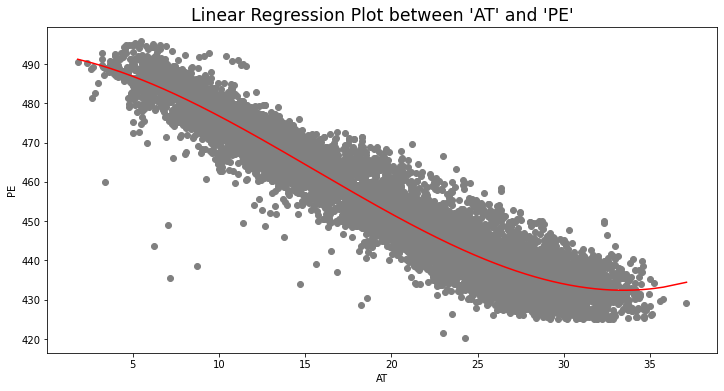

In [14]:
# polynomial LinReg - 1 predictor : AT

# fit linear regression
linreg_AT_poly = smf_linear_regression('PE ~ 1 + AT + I(AT ** 2.0) + I(AT ** 3.0)', df_ccpp)
print(linreg_AT_poly.summary())
print('MSE of nonlinear regression using AT:', mean_squared_error(y_train, linreg_AT_poly.predict(df_ccpp)))

# plot raw data and polynomial linear regressor
plot_linreg_poly(df_ccpp[['AT']], df_ccpp['PE'], linreg_AT_poly)

> The quadratic and cubic forms of feature 'AT' are statistically significant as their p-values are 0.000

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 1.098e+04
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:31:41   Log-Likelihood:                -33585.
No. Observations:                9568   AIC:                         6.718e+04
Df Residuals:                    9564   BIC:                         6.721e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     554.1468      9.151     60.557      

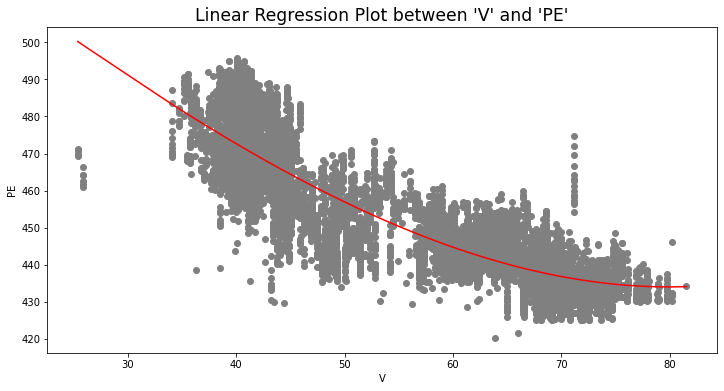

In [15]:
# polynomial LinReg - 1 predictor : V

# fit linear regression
linreg_V_poly = smf_linear_regression('PE ~ 1 + V + I(V ** 2.0) + I(V ** 3.0)', df_ccpp)
print(linreg_V_poly.summary())
print('MSE of nonlinear regression using V:', mean_squared_error(y_train, linreg_V_poly.predict(df_ccpp)))

# plot raw data and polynomial linear regressor
plot_linreg_poly(df_ccpp[['V']], df_ccpp['PE'], linreg_V_poly)


> The quadratic form of feature 'V' is not statistically significant as its p-value is 0.768. However, its cubic form is statistically significant with p-value at 0.014

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     1813.
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:31:41   Log-Likelihood:                -39184.
No. Observations:                9568   AIC:                         7.837e+04
Df Residuals:                    9565   BIC:                         7.840e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0747      0.009      8.415   

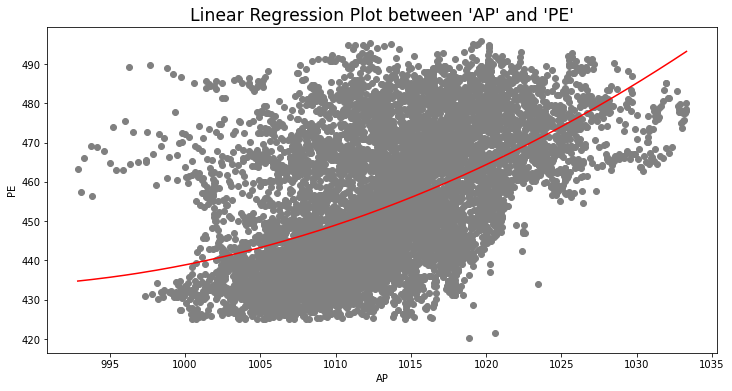

In [16]:
# polynomial LinReg - 1 predictor : AP

# fit linear regression
linreg_AP_poly = smf_linear_regression('PE ~ 1 + AP + I(AP ** 2.0) + I(AP ** 3.0)', df_ccpp)
print(linreg_AP_poly.summary())
print('MSE of nonlinear regression using AP:', mean_squared_error(y_train, linreg_AP_poly.predict(df_ccpp)))

# plot raw data and polynomial linear regressor
plot_linreg_poly(df_ccpp[['AP']], df_ccpp['PE'], linreg_AP_poly)


> The quadratic and cubic forms of feature 'AP' are statistically significant as their p-values are 0.000

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     579.2
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:31:41   Log-Likelihood:                -39923.
No. Observations:                9568   AIC:                         7.985e+04
Df Residuals:                    9564   BIC:                         7.988e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      468.4135     10.545     44.422   

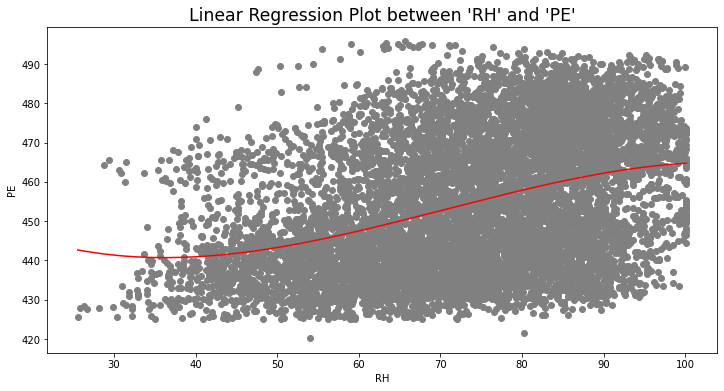

In [17]:
# polynomial LinReg - 1 predictor : RH

# fit linear regression
linreg_RH_poly = smf_linear_regression('PE ~ 1 + RH + I(RH ** 2.0) + I(RH ** 3.0)', df_ccpp)
print(linreg_RH_poly.summary())
print('MSE of nonlinear regression using RH:', mean_squared_error(y_train, linreg_RH_poly.predict(df_ccpp)))

# plot raw data and polynomial linear regressor
plot_linreg_poly(df_ccpp[['RH']], df_ccpp['PE'], linreg_RH_poly)


> The quadratic and cubic forms of feature 'RH' are statistically significant as their p-values are 0.000

# (g) Is there evidence of association of interactions of predictors with the response? To answer this question, run a full linear regression model with all pairwise interaction terms and state whether any interaction terms are statistically significant.

In [18]:
# full linear regression with all pairwise interaction terms
model = 'PE ~ 1 + AT + V + AP + RH + AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH'
linreg_interaction = smf_linear_regression(model, df_ccpp)
print(linreg_interaction.summary())
print('MSE of regression with interaction terms:', mean_squared_error(y_train, linreg_interaction.predict(df_ccpp)))


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:31:41   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    685.7825     78.640      8.721      0.0

> From the 6 pairwise interaction terms, there are 4 terms that show statistical significance: AT:V (p-value 0.000), AT:RH (p-value 0.000), V:AP (p-value 0.000), and AP:RH (p-value 0.034). The other 2 interaction terms are not statistically significant as their p-value exceed 0.05: AT:AP (p-value 0.452), V:RH (p-value 0.086)

# (h) Can you improve your model using possible interaction terms or nonlinear associations between the predictors and response? Train the regression model on a randomly selected 70% subset of the data with all predictors. Also, run a regression model involving all possible interaction terms and quadratic nonlinearities, and remove insignificant variables using p-values (be careful about interaction terms). Test both models on the remaining points and report your train and test MSEs.

In [19]:
# split training and testing sets
df_ccpp_train, df_ccpp_test = train_test_split(df_ccpp, test_size = 0.3, random_state = 1)

In [20]:
# train LinReg using only linear features
model_linear = 'PE ~ 1 + AT + V + AP + RH'

linreg_linear = smf_linear_regression(model_linear, df_ccpp_train)
print(linreg_linear.summary())

print('Training MSEs:', mean_squared_error(df_ccpp_train['PE'], linreg_linear.predict(df_ccpp_train[['AT', 'V', 'AP', 'RH']])))
print('Testing MSEs:', mean_squared_error(df_ccpp_test['PE'], linreg_linear.predict(df_ccpp_test[['AT', 'V', 'AP', 'RH']])))


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 2.167e+04
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:31:41   Log-Likelihood:                -19660.
No. Observations:                6697   AIC:                         3.933e+04
Df Residuals:                    6692   BIC:                         3.936e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    458.3988     11.562     39.649      0.0

In [21]:
# train LinReg using all interaction terms and quadratic nonlinearities
model_poly_interaction = '''PE ~ 1 + AT + V + AP + RH + \
    I(AT ** 2.0) + I(V ** 2.0) + I(AP ** 2.0) + I(RH ** 2.0) + \
    AT*V + AT*AP + AT*RH + V*AP + V*RH + AP*RH
'''

linreg_all_poly_interaction = smf_linear_regression(model_poly_interaction, df_ccpp_train)
print(linreg_all_poly_interaction.summary())

print('Training MSEs:', mean_squared_error(df_ccpp_train['PE'], linreg_all_poly_interaction.predict(df_ccpp_train[['AT', 'V', 'AP', 'RH']])))
print('Testing MSEs:', mean_squared_error(df_ccpp_test['PE'], linreg_all_poly_interaction.predict(df_ccpp_test[['AT', 'V', 'AP', 'RH']])))


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     7181.
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:31:41   Log-Likelihood:                -19192.
No. Observations:                6697   AIC:                         3.841e+04
Df Residuals:                    6682   BIC:                         3.852e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -8171.8080   1416.708     -5.768   

> - When including all quadratic and interaction terms in the regression model, the performance improves as its training MSE decreases from 20.766 to 18.060 and testing MSE decreases from 20.777 to 18.217. The R-squared also improves from 0.928 to 0.938.
> - However, there are terms that are not statistically significant which are AT, V ** 2, AT:AP, V:AP, V:RH which will be removed in the next step (we'll keep the base term AT)

In [22]:
# train LinReg using statiscally-significant interaction terms and quadratic nonlinearities (keep base terms)
model_poly_interaction_sig = '''PE ~ 1 + AT + V + AP + RH + \
    I(AT ** 2.0) + I(AP ** 2.0) + I(RH ** 2.0) + \
    AT*V + AT*RH + AP*RH
'''

linreg_all_poly_interaction_sig = smf_linear_regression(model_poly_interaction_sig, df_ccpp_train)
print(linreg_all_poly_interaction_sig.summary())

print('Training MSEs:', mean_squared_error(df_ccpp_train['PE'], linreg_all_poly_interaction_sig.predict(df_ccpp_train[['AT', 'V', 'AP', 'RH']])))
print('Testing MSEs:', mean_squared_error(df_ccpp_test['PE'], linreg_all_poly_interaction_sig.predict(df_ccpp_test[['AT', 'V', 'AP', 'RH']])))


                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 1.004e+04
Date:                Fri, 11 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:31:41   Log-Likelihood:                -19198.
No. Observations:                6697   AIC:                         3.842e+04
Df Residuals:                    6686   BIC:                         3.849e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.052e+04   1079.936     -9.738   

> - After removing all non statistically significant quadratic and interaction terms, the remaining terms are still significant after training. Compared to the model using all terms, the R-squared remains the same at 0.938 but the training and testing MSEs slightly increase from 18.060 to 18.093 and 18.217 to 18.264 respectively
> - However, comparing this model (quadratic and interaction after removing insig terms) to the base model (multiple linear regression, the performance improves as R-squared increase from 0.928 to 0.938, training MSE decreases from 20.766 to 18.093, and testing MSE decreases from 20.777 to 18.264

# (i) KNN Regression

<font size = "3"><b> (i)-i. Perform k-nearest neighbor regression for this dataset using both normalized and raw features. Find the value of k ∈ {1,2,...,100} that gives you the best fit. Plot the train and test errors in terms of 1/k.</font>

In [33]:
# define list of k to train the KNN regressor
list_k = np.arange(1, 101)

# normalize independent variables
scaler = StandardScaler()
scaler.fit(df_ccpp_train)
df_ccpp_train_norm = pd.DataFrame(scaler.transform(df_ccpp_train), columns = ['AT', 'V', 'AP', 'RH', 'PE'])
df_ccpp_test_norm = pd.DataFrame(scaler.transform(df_ccpp_test), columns = ['AT', 'V', 'AP', 'RH', 'PE'])

# create df to store results
df_result_knn = pd.DataFrame(columns = ['feature_type', 'k', 'training_mse', 'testing_mse'])

#### KNN Regressor using raw features

In [34]:
# KNN Regressor using raw features

for k in list_k:
    knn_regressor = KNeighborsRegressor(n_neighbors = k)
    knn_regressor.fit(df_ccpp_train[['AT', 'V', 'AP', 'RH']], df_ccpp_train['PE'])
    training_mse = mean_squared_error(df_ccpp_train['PE'], knn_regressor.predict(df_ccpp_train[['AT', 'V', 'AP', 'RH']]))
    testing_mse = mean_squared_error(df_ccpp_test['PE'], knn_regressor.predict(df_ccpp_test[['AT', 'V', 'AP', 'RH']]))
    df_result_knn.loc[len(df_result_knn), :] = ['raw', k, training_mse, testing_mse]
    

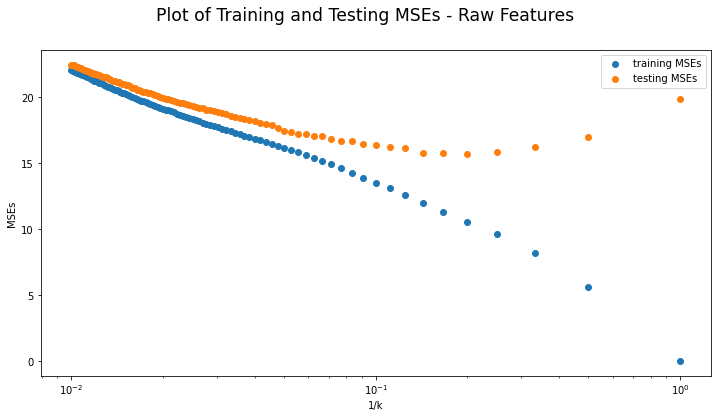

In [35]:
# Plot training and testing errors for different k values
df_result_knn_raw = df_result_knn[df_result_knn.feature_type == 'raw']

plt.scatter(1/df_result_knn_raw['k'], df_result_knn_raw['training_mse'], label = 'training MSEs')
plt.scatter(1/df_result_knn_raw['k'], df_result_knn_raw['testing_mse'], label = 'testing MSEs')

plt.rcParams["figure.figsize"] = (12,6)
plt.suptitle('Plot of Training and Testing MSEs - Raw Features', fontsize = 'xx-large')
plt.xlabel('1/k')
plt.ylabel('MSEs')
plt.xscale('log')
plt.legend()
plt.show()

In [36]:
print(df_result_knn[(df_result_knn.testing_mse == df_result_knn.testing_mse.min()) & (df_result_knn.feature_type == 'raw')])

  feature_type  k training_mse testing_mse
4          raw  5    10.552961   15.704821


> When using raw features to train KNN regression, the optimal k is when k equals to 5. This gives a training MSE at 10.553 and testing MSE at 15.705

#### KNN Regressor using normalized features

In [37]:
# KNN Regressor using normalized features

for k in list_k:
    knn_regressor_norm = KNeighborsRegressor(n_neighbors = k)
    knn_regressor_norm.fit(df_ccpp_train_norm[['AT', 'V', 'AP', 'RH']], df_ccpp_train['PE'])
    training_mse = mean_squared_error(df_ccpp_train['PE'], knn_regressor_norm.predict(df_ccpp_train_norm[['AT', 'V', 'AP', 'RH']]))
    testing_mse = mean_squared_error(df_ccpp_test['PE'], knn_regressor_norm.predict(df_ccpp_test_norm[['AT', 'V', 'AP', 'RH']]))
    df_result_knn.loc[len(df_result_knn), :] = ['normalized', k, training_mse, testing_mse]
    

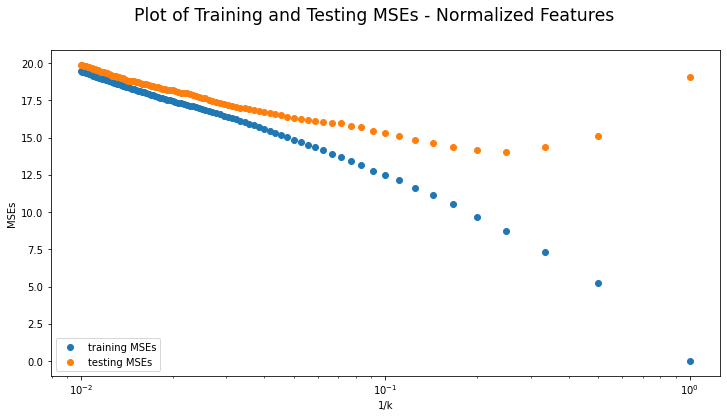

In [38]:
# Plot training and testing errors for different k values
df_result_knn_normalized = df_result_knn[df_result_knn.feature_type == 'normalized']

plt.scatter(1/df_result_knn_normalized['k'], df_result_knn_normalized['training_mse'], label = 'training MSEs')
plt.scatter(1/df_result_knn_normalized['k'], df_result_knn_normalized['testing_mse'], label = 'testing MSEs')

plt.rcParams["figure.figsize"] = (12,6)
plt.suptitle('Plot of Training and Testing MSEs - Normalized Features', fontsize = 'xx-large')
plt.xlabel('1/k')
plt.ylabel('MSEs')
plt.xscale('log')
plt.legend()
plt.show()

In [39]:
print(df_result_knn[(df_result_knn.testing_mse == df_result_knn.testing_mse.min()) & (df_result_knn.feature_type == 'normalized')])

    feature_type  k training_mse testing_mse
103   normalized  4     8.738516   14.070606


> When normalizing the predictors to train KNN regression, the optimal k is when k equals to 4. The performance improves as the training MSE is at 8.739 and the testing MSE is at 14.071

# (j) Compare the results of KNN Regression with the linear regression model that has the smallest test error and provide your analysis.

> - Smallest test error from linear regression model is the model including quadratic and interaction terms after removing insignificant features (not considering all quadratic and interaction terms). This model gives a training error (MSE) at 18.093 and testing error (MSE) at 18.264
> - Smallest test error from KNN regression is the model that uses normalized predictors when k = 4. The model gives a training error (MSE) at 8.73 and testing error (MSE) at 14.071.
> - For this training purpose, KNN Regression outperforms Linear Regression when comparing their MSEs. This could be because KNN fits to nonlinearity in data better as a non-parametric method while a parametric method like Linear Regression requires assumption on which form the model should be trained (in our case we explicitly assign quadratic and interaction terms) which might not be enough to explain the relationship in the data.

# ISLR: 2.4.1

#### For each of parts (a) through (d), indicate whether we would generally expect the performance of a flexible statistical learning method to be better or worse than an inflexible method. Justify your answer.

##### (a) The sample size n is extremely large, and the number of predictors p is small.

> In the case of large sample size and small number of predictors, we would expect the performance of a flexible model to be better. This is because the fact that a flexible model has less bias and will be less likely to overfit (high variance) because of the large sample size.

##### (b) The number of predictors p is extremely large, and the number of observations n is small.

> In the case of small sample size and large number of predictors, we would expect the performance of an inflexible model to be better. Since this condition is more likely for model to be overfitting or high variance, choosing an inflexible model would help avoid having high variance better than a flexible model.

##### (c) The relationship between the predictors and response is highly non-linear.

> In the case of non-linearity, we would expect the performance of a flexible model to be better. This is because we need the high flexibility of the model in order to fit the nonlinearity. Otherwise, the model would be too simple to capture the nonlinearity and result in low performance.

##### (d) The variance of the error terms, i.e. σ2 = Var(ε), is extremely high.

> In the case of high variance of the error terms, we would expect an inflexible model to perform better. This is because a flexible model will try to capture noises and therefore result in a worse testing performance.

# ISLR: 2.4.7

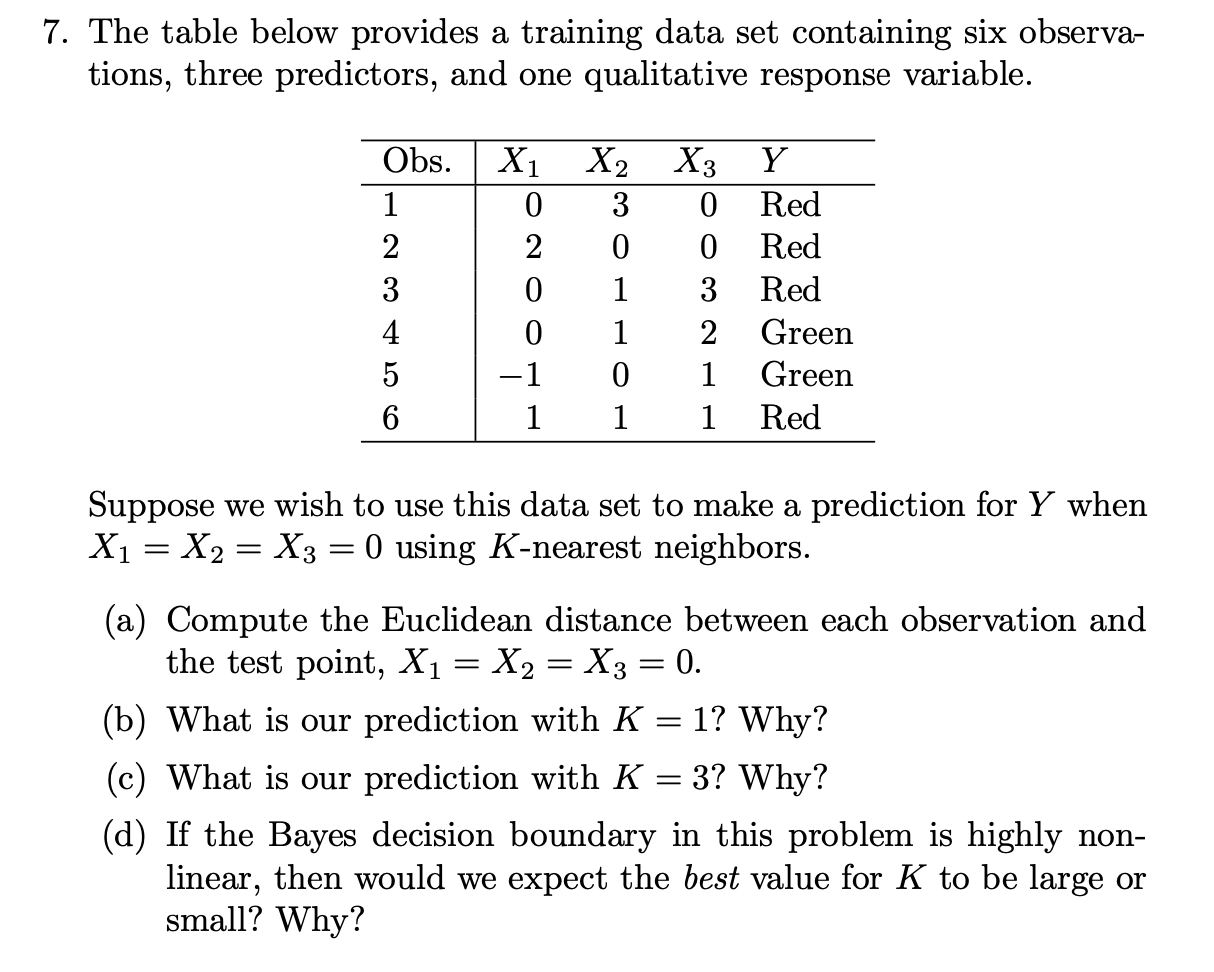

#### calculation by hand

>Find euclidean distance between each observation and test point x1 = x2 = x3 = 0
<br><br>
obs1: <br>
euclidean_distance = sqrt( delta_x1 ^ 2 + delta_x2 ^ 2 + delta_x3 ^ 2 ) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; = sqrt( (0-0) ^ 2 + (3-0) ^ 2 + (0-0) ^ 2) = 3 <br><br>
obs2: <br>
euclidean_distance = sqrt( delta_x1 ^ 2 + delta_x2 ^ 2 + delta_x3 ^ 2 ) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; = sqrt( (2-0) ^ 2 + (0-0) ^ 2 + (0-0) ^ 2) = 2 <br><br>
obs3: <br>
euclidean_distance = sqrt( delta_x1 ^ 2 + delta_x2 ^ 2 + delta_x3 ^ 2 ) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; = sqrt( (0-0) ^ 2 + (1-0) ^ 2 + (3-0) ^ 2) = 3.16 <br><br>
obs4: <br>
euclidean_distance = sqrt( delta_x1 ^ 2 + delta_x2 ^ 2 + delta_x3 ^ 2 ) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; = sqrt( (0-0) ^ 2 + (1-0) ^ 2 + (2-0) ^ 2) = 2.24 <br><br>
obs5: <br>
euclidean_distance = sqrt( delta_x1 ^ 2 + delta_x2 ^ 2 + delta_x3 ^ 2 ) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; = sqrt( (-1-0) ^ 2 + (0-0) ^ 2 + (1-0) ^ 2) = 1.41 <br><br>
obs6: <br>
euclidean_distance = sqrt( delta_x1 ^ 2 + delta_x2 ^ 2 + delta_x3 ^ 2 ) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; = sqrt( (1-0) ^ 2 + (1-0) ^ 2 + (1-0) ^ 2) = 1.73 <br><br>

> Prediction for K = 1 will be 'Green' as the 1 nearest point to the test point is Obs.5 whose y value is 'Green'

> Prediction for K = 3 will be 'Red' as the 3 nearest points to the test point are Obs.2, Obs.5, and Obs.6 whose y values are 'Red', 'Green', and 'Red' respectively. Using majority polling, the prediction for the test point will be 'Red' (2/3 votes)

> If Bayes decision boundary is highly non-linear, we expect the best value for K to be small as small K value makes the model more flexible, meaning that it could capture nonlinearity better. On the other hand, large K value would generalize the model too much and wouldn't be able to draw a complex non-linear decision boundary.

#### calculation by program

In [30]:
# define a dataset
df2 = pd.DataFrame({'obs' : [1, 2, 3, 4, 5, 6], 'x1' : [0, 2, 0, 0, -1, 1], 'x2':[3, 0, 1, 1, 0, 1], 'x3':[0, 0, 3, 2, 1, 1], 'y':['red', 'red', 'red', 'green', 'green', 'red']})
df2.set_index(['obs'], inplace = True)
X_train = df2[['x1', 'x2', 'x3']]
y_train = df2['y']
X_test = pd.DataFrame({'x1' : [0], 'x2':[0], 'x3':[0]})


In [31]:
# euclidean distance between each observation and test point

euclidean_dist = pd.DataFrame(cdist(X_train, X_test, metric='euclidean'), index = df2.index, columns = ['euclidean_distance'])
print(euclidean_dist)


     euclidean_distance
obs                    
1              3.000000
2              2.000000
3              3.162278
4              2.236068
5              1.414214
6              1.732051


In [32]:
# fit the knn classifier and predict - for K = 1 and K = 3
knn_cls_1 = KNeighborsClassifier(n_neighbors = 1)
knn_cls_1.fit(X_train, y_train)
print('With K = 1, the KNN Classifier predicts the test point to be class (y)', knn_cls_1.predict(X_test)[0])

knn_cls_3 = KNeighborsClassifier(n_neighbors = 3)
knn_cls_3.fit(X_train, y_train)
print('With K = 3, the KNN Classifier predicts the test point to be class (y)', knn_cls_3.predict(X_test)[0])

With K = 1, the KNN Classifier predicts the test point to be class (y) green
With K = 3, the KNN Classifier predicts the test point to be class (y) red


> If Bayes decision boundary is highly non-linear, we expect the best value for K to be small as small K value makes the model more flexible, meaning that it could capture nonlinearity better. On the other hand, large K value would generalize the model too much and wouldn't be able to draw a complex non-linear decision boundary.